# Create and share a reference atlas

In this notebook, we are going to build a reference pancreas atlas and share the model weights

In [2]:
import scarches as sca
import scanpy as sc
sc.settings.set_figure_params(dpi=100, frameon=False, facecolor='white')

Using TensorFlow backend.


`condition_key` is the column name which stores batch id in your `adata.obs`

In [48]:
condition_key = "study"

### Load reference atlas

In [5]:
adata = sca.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 15681 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

We hold out two out of five studies for later use in another tutorial 

In [30]:
adata = adata[~adata.obs[condition_key].isin(['Pancreas CelSeq2', 'Pancreas SS2'])]

### Create scArches network from scratch 

There are some parameters that worth to be mentioned here:

1. __task_name__: name of the task (i.e dataset) which you are going to train scArches on it.
2. __x_dimension__: number of dimensions in expression space
3. __z_dimension__: number of dimensions in latent space of scArches
4. __n_conditions__: number of conditions (batches, datasets, or domains)
5. __gene_names__: list of gene names used as scArches' input
6. __model_path__: path to save trained scArches model and its configuration files.
7. __alpha__: KL divergence coefficient for VAE. Biger alpha (1<=alpha<=0.1)  -> better mixing , small alpha (alpha <= 0.001): good mixing while having disctinct cell types
9. __loss_fn__: loss function to be used in scArches. Can be one of `mse`, `sse`, `nb`, or `zinb`. Please __NOTE__ that If you are going to use `nb` or `zinb` loss function, we suggest that setting `beta` hyperparameter to zero will be the best config for scArches to train on your task. 

__Note__ : `nb` (negative binomial) and `zinb` (zero inflated `nb`) require raw count data in your `adata.raw.X` and normalaized log-transformed values in `adata.X`

__HINT__ : we recommend to use `nb` loss, however if you did not find the results satisfying then consider using `sse`

In [41]:
network = sca.models.scArches(task_name='pancreas_inDropCelSeqFC1',
                              x_dimension=adata.shape[1], 
                              z_dimension=10,
                              architecture=[128, 128],
                              gene_names=adata.var_names.tolist(),
                              conditions=adata.obs[condition_key].unique().tolist(),
                              alpha=0.001,
                              loss_fn='sse',
                              model_path="./models/scArches/",
                              )

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!


### Train 

You can train scArches with `train` function with the following parameters:

1. __adata__: Annotated dataset used for training and evaluating scArches.
2. __condition_key__: name of the column in `obs` matrix in `adata` which contains the conditions for each sample.
3. __n_epochs__: number of epochs used to train scArches.
4. __batch_size__: number of sample used to sample as mini-batches in order to optmize scArches. 
8. __save__: whether to save scArches' model and configs after training phase or not. 
9. __retrain__: if `False` and scArches' pretrained model exists in `model_path`, will restore scArches' weights. Otherwise will train and validate scArches on `adata`. 

In [42]:
network.train(adata,
              condition_key=condition_key,
              n_epochs=100,
              batch_size=128, 
              save=True, 
              retrain=True)

 |████████████████████| 100.0%  - loss: 474.1160 - mmd_loss: 4.2231 - recon_loss: 469.8929 - val_loss: 960.2698 - val_mmd_loss: 22.9883 - val_recon_loss: 937.2815

scArches has been successfully saved in ./models/scArches/pancreas_inDropCelSeqFC1.


### UMAP visualization of latent space

Latent space representation of reference data can be obtained using `get_latent` function
This function has the following parameters:

1. __adata__: Annotated dataset to be transformed to latent space
2. __condition_key__: Name of the column in `obs` matrix in `adata` which contains the study for each sample.


In [45]:
latent_adata = network.get_latent(adata, condition_key, return_z=True)

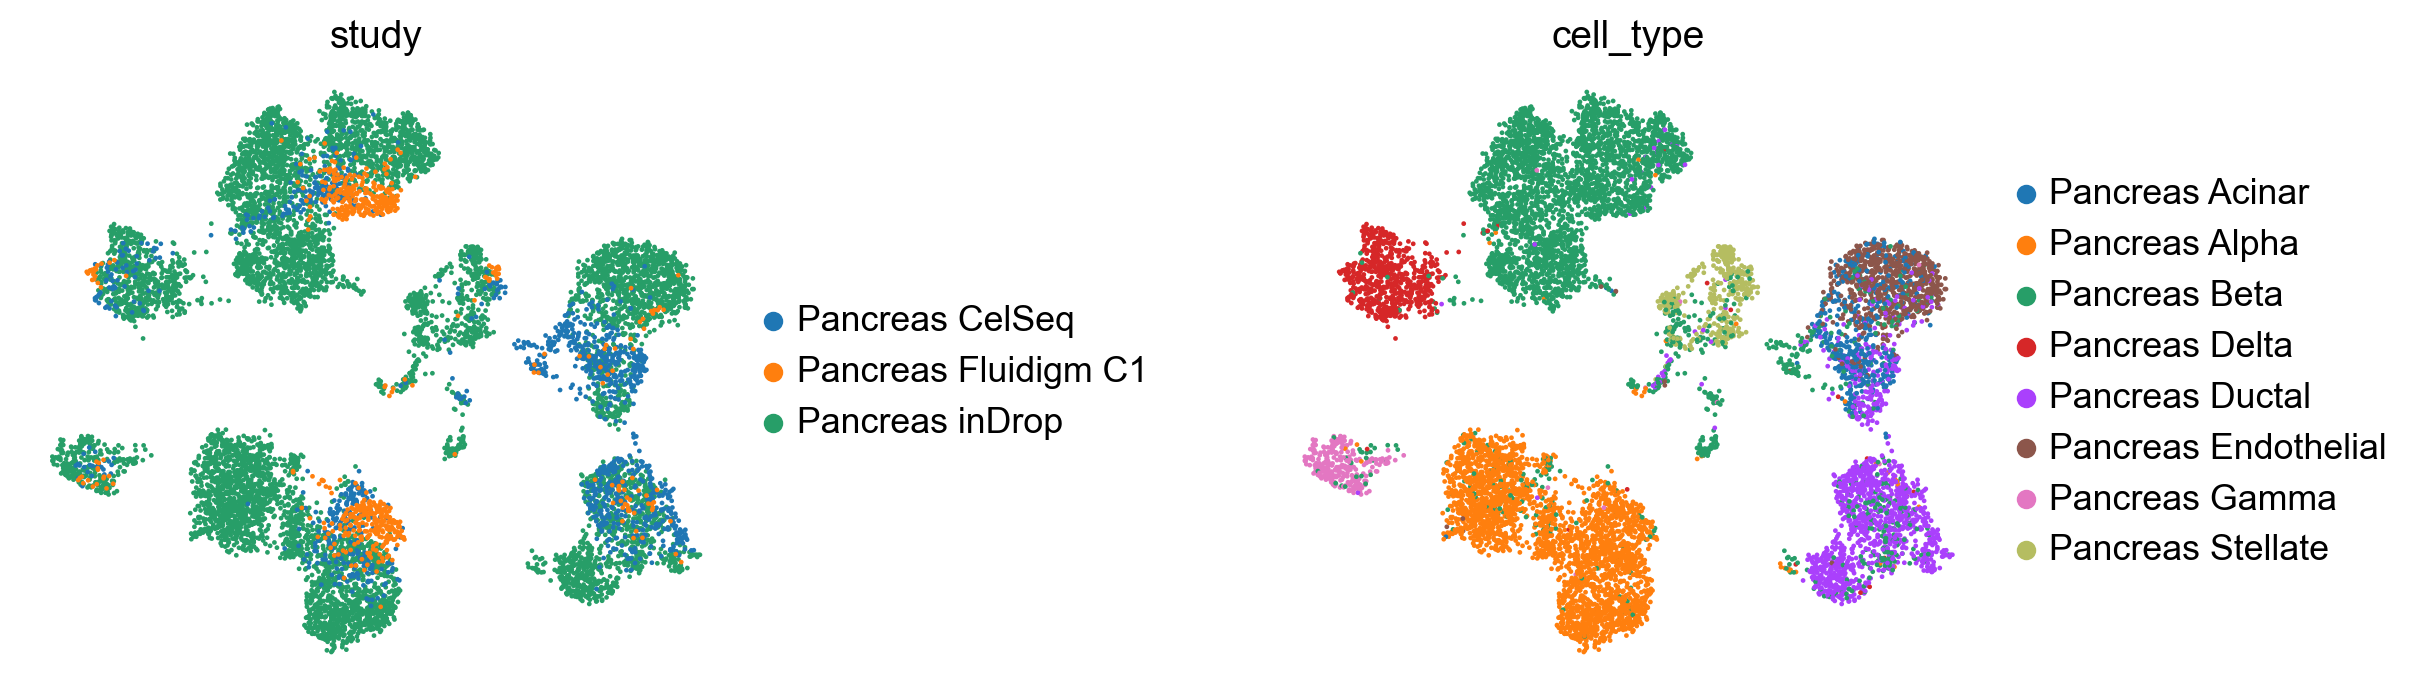

In [47]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(latent_adata, color=[condition_key, "cell_type"], 
           frameon=False, wspace=0.6)

### Share Your Trained scArches with other researchers

You can easily get TOKEN by signing up in [**Zenodo**](https://zenodo.org/) Website and creating an app in the settings. You just have to following these steps for creating a new TOKEN: 

1. Sign in/Register in [__Zenodo__](https://zenodo.org/)
2. Go to __Applications__ page.
3. Click on __new_token__ in __Personal access tokens__ panel.
4. Give it access for `deposit:actions` and `deposit:write`.

__NOTE__: Zenodo will show the created TOKEN only once so be careful in preserving it. If you lost your TOKEN you have to create new one.

In [13]:
ACCESS_TOKEN = "GJFuigslmTKhN3CbI6Zfk7qW0uQAutxPHE8vutyDPB36McOkYbUw4aKDbBCz"

### 1. Create a Deposition in your zenodo account

You can use wrapper functions in `zenodo` module in scArches package to interact with your depositions and uploaded files in Zenodo. In Zenodo, A deposition is a cloud space for a publication, poster, etc which contains multiple files.

In order to create a deposition in Zenodo, You can call our `create_deposition` function with the following parameters:

-  __access_token__: Your access token
-  __upload_type__: Type of the deposition, has to be one of the following types defined in [here](https://developers.zenodo.org/#representation).
-  __title__: Title of the deposition.
-  __description__: Description of the deposition.
-  __creators__: List of creators of this deposition. Each item in the list has to be in the following form:

```
{
    "name": "LASTNAME, FIRSTNAME", (Has to be in this format)
    "affiliation": "AFFILIATION", (Optional)
    "orcid": "ORCID" (Optional, has to be a valid ORCID)
}
```





In [15]:
deposition_id = sca.zenodo.create_deposition(ACCESS_TOKEN, 
                                             upload_type="other", 
                                             title='scArches-pancreas',
                                             description='pre-trained scArches on inDrop, CelSeq, CelSeq2, SmartSeq2, and Fluidigm C1',                                            
                                             creators=[
                                                 {"name": "Naghipourfar, Mohsen", "affiliation": "SUT"},
                                             ],
                                             )

New Deposition has been successfully created!


### 2. Upload your model to your deposition

After creating a deposition, you can easily upload your pre-trained scArches model using `upload_model` function in `zenodo` module. This function accepts the following parameters:

- __model__: Instance of scArches' class which is trained on your task
- __deposition_id__: ID of the deposition you want to upload the model in.
- __access_token__: Your TOKEN.

The function will return the generated `download_link` in order to use and provide other 

In [16]:
download_link = sca.zenodo.upload_model(network, 
                                        deposition_id=deposition_id, 
                                        access_token=ACCESS_TOKEN)

Model has been successfully uploaded


### 3. Publish the created deposition

In [17]:
sca.zenodo.publish_deposition(deposition_id, ACCESS_TOKEN)

Deposition with id = 3930127 has been successfully published!


In [18]:
download_link

'https://zenodo.org/record/3930127/files/scNet-pancreas_inDropCelSeqFC1.zip?download=1'

### Congrats! Your model is ready to be downloaded by others researchers!